## Import libraries

In [1]:
#  Data structures
import numpy as np
import pandas as pd
import pickle

#  Metrics
import scipy.stats as st
from sklearn import metrics

#  Modelling and evaluation
import xgboost as xgb

#  Visualisation
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

#  Styling and control
%precision 3
pd.options.mode.chained_assignment = None

#  Custom modules, located in ./modules
import sys
sys.path.insert(0, r'.\modules')
from ml_helpers import *
from lc_helpers import *
from random_helpers import *
from xgb_train import xgb_train
from xgb_evaluate import xgb_evaluate

#  General variables
VERSION = set_version(r'.\objects\lc_grid_version.dat')
iteration = 0
print(f'Version: {VERSION}')

Sucessfully opened .\objects\lc_grid_version.dat
Version: 18


## Load engineered data

In [2]:
%%time

target_cols = ['loan_status']
X_y = pickle_or_alt(r'./objects/lc_data_engineered_size_3_new.dat')
X_train, X_eval, X_test, y_train, y_eval, y_test = recreate_sets(X_y, target_cols)
ratio_0_1 = len(X_y[X_y[target_cols[0]] == 0][target_cols[0]]) / len(X_y[X_y[target_cols[0]] == 1][target_cols[0]])
xgb_params = txt_to_dict(r'.\settings\xgb_grid_params.txt')
xgb_params['scale_pos_weight'] = xgb_params['scale_pos_weight_factor'] * ratio_0_1

Sucessfully opened ./objects/lc_data_engineered_size_3_new.dat
Wall time: 3.96 s


## Perform grid search

In [3]:
%%time

runs = 5
grid = []
best_f1 = .0
print(ratio_0_1)

for i in range(runs):
    #  Update version
    iteration +=1
    version_string = str(VERSION)+'_'+str(iteration)
    grid.append({})

    #  Set grid params
    grid_params = xgb_params
    grid_params['n_estimators'] = 100 #rand_uniform(400, 900, decimals=0) #500
    grid_params['early_stopping_rounds'] = 30 #rand_uniform(10, 100, decimals=0) #40
    grid_params['max_depth'] = i+3 #rand_choice([2, 7]) #6
    grid_params['learning_rate'] = 0.16 #rand_log(low=0.1, high=0.5) 
    grid_params['min_child_weight'] = 3.11 #rand_log(low=3., high=3.5)
    grid_params['gamma'] = 0.0004 #rand_log(low=0., high=0.15) #0.1
    grid_params['subsample'] = 1 #rand_uniform(0.9, 1)
    grid_params['colsample_bytree'] = 0.95 #rand_uniform(0.9, 1)
    grid_params['max_delta_step'] = 5 #rand_uniform(4, 6, decimals=0)
    grid_params['scale_pos_weight_factor'] = 0.79 #rand_uniform(0.65, 0.85)
    grid_params['scale_pos_weight'] = grid_params['scale_pos_weight_factor'] * ratio_0_1
    grid[i]['params'] = grid_params.copy()
    
    print(f'\n---\nGrid search {version_string}')
    print(f'Run {i + 1}/{runs}')
    print('Parameters:')
    for p in grid_params:
        print(f'{p}: {grid_params[p]}')    
    print()

    #  Train model
    xgb_model, xgb_features = xgb_train(X_train, X_eval, X_test, y_eval, y_train, grid_params)
    grid[i]['features'] = xgb_features
    grid[i]['model'] = xgb_model

    #  Predict outcomes of the test data
    xgb_preds = xgb_model.predict(X_test.as_matrix())

    #  Evaluate predictions
    sets = ['unknown']
    truths = y_test.reset_index(drop=True)
    evaluation = xgb_evaluate(xgb_preds, truths, xgb_features, xgb_params, sets, VERSION, iteration)
    f1 = evaluation['f1']
    grid[i]['evaluation'] = evaluation
    grid[i]['f1'] = float(f1)
    
    print(f'\nF1 score for {version_string}: {f1:.3%}')

    #  Determine best
    if f1 > best_f1:
        best = True
        best_f1 = f1
        print('Best result so far\n')
    else:
        best = False
        print(f'Not better than {best_f1:.3%}\n')

    #  Save trained model and feature objects
    pickle_save(xgb_model, r'.\objects\lc_grid_model_' + version_string + '.dat')
    pickle_save(xgb_features, r'.\objects\lc_grid_xgb_features_' + version_string + '.dat')

    #  Save evaluation statistics to .txt file
    txt = open(r'.\evaluations\lc_grid_evaluation_' + version_string + '.txt', 'w')
    txt.write(evaluation['string'])
    txt.close()
    
    #  Save grid object
    pickle_save(grid, r'.\objects\lc_grid_' + version_string + '.dat')

    #  if best, repeat the above
    if best:
        pickle_save(xgb_model, r'.\objects\lc_grid_best_model_' + str(VERSION) + '.dat')
        pickle_save(xgb_features, r'.\objects\lc_grid_best_xgb_features_' + str(VERSION) + '.dat')
        txt = open(r'.\evaluations\lc_grid_best_evaluation_' + str(VERSION) + '.txt', 'w')
        txt.write(evaluation['string'])
        txt.close()

7.32463008964251

---
Grid search 18_1
Run 1/5
Parameters:
booster: gbtree
objective: binary:logistic
eval_metric: auc
n_estimators: 100
max_depth: 3
learning_rate: 0.16
min_child_weight: 3.11
gamma: 0.0004
subsample: 1
colsample_bytree: 0.95
max_delta_step: 5
scale_pos_weight_factor: 0.79
early_stopping_rounds: 30
silent: 1
n_jobs: 8
tree_method: exact
scale_pos_weight: 5.7864577708175835

[0]	validation_0-auc:0.891691
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.904776
[2]	validation_0-auc:0.9107
[3]	validation_0-auc:0.915165
[4]	validation_0-auc:0.915707
[5]	validation_0-auc:0.923377
[6]	validation_0-auc:0.928309
[7]	validation_0-auc:0.931083
[8]	validation_0-auc:0.933939
[9]	validation_0-auc:0.935427
[10]	validation_0-auc:0.936779
[11]	validation_0-auc:0.938582
[12]	validation_0-auc:0.942151
[13]	validation_0-auc:0.943182
[14]	validation_0-auc:0.944825
[15]	validation_0-auc:0.94837
[16]	validation_0-auc:0.948226
[17]	validation_0-auc:0.9509

[3]	validation_0-auc:0.959393
[4]	validation_0-auc:0.960446
[5]	validation_0-auc:0.962076
[6]	validation_0-auc:0.962983
[7]	validation_0-auc:0.966488
[8]	validation_0-auc:0.96755
[9]	validation_0-auc:0.968215
[10]	validation_0-auc:0.968819
[11]	validation_0-auc:0.969119
[12]	validation_0-auc:0.969207
[13]	validation_0-auc:0.969773
[14]	validation_0-auc:0.97125
[15]	validation_0-auc:0.971541
[16]	validation_0-auc:0.973025
[17]	validation_0-auc:0.974113
[18]	validation_0-auc:0.974518
[19]	validation_0-auc:0.975156
[20]	validation_0-auc:0.97552
[21]	validation_0-auc:0.976125
[22]	validation_0-auc:0.976213
[23]	validation_0-auc:0.976196
[24]	validation_0-auc:0.976608
[25]	validation_0-auc:0.977142
[26]	validation_0-auc:0.977404
[27]	validation_0-auc:0.977336
[28]	validation_0-auc:0.977637
[29]	validation_0-auc:0.978627
[30]	validation_0-auc:0.979217
[31]	validation_0-auc:0.980035
[32]	validation_0-auc:0.980587
[33]	validation_0-auc:0.980599
[34]	validation_0-auc:0.980904
[35]	validation_0-

[20]	validation_0-auc:0.984412
[21]	validation_0-auc:0.984886
[22]	validation_0-auc:0.985125
[23]	validation_0-auc:0.985212
[24]	validation_0-auc:0.985377
[25]	validation_0-auc:0.985439
[26]	validation_0-auc:0.985639
[27]	validation_0-auc:0.986204
[28]	validation_0-auc:0.986472
[29]	validation_0-auc:0.98657
[30]	validation_0-auc:0.986925
[31]	validation_0-auc:0.987071
[32]	validation_0-auc:0.987362
[33]	validation_0-auc:0.987476
[34]	validation_0-auc:0.988331
[35]	validation_0-auc:0.988744
[36]	validation_0-auc:0.989117
[37]	validation_0-auc:0.989678
[38]	validation_0-auc:0.990194
[39]	validation_0-auc:0.990457
[40]	validation_0-auc:0.991092
[41]	validation_0-auc:0.991398
[42]	validation_0-auc:0.991446
[43]	validation_0-auc:0.991717
[44]	validation_0-auc:0.992045
[45]	validation_0-auc:0.992286
[46]	validation_0-auc:0.992506
[47]	validation_0-auc:0.992742
[48]	validation_0-auc:0.992867
[49]	validation_0-auc:0.992999
[50]	validation_0-auc:0.99309
[51]	validation_0-auc:0.993262
[52]	valid

## Visualise grid search

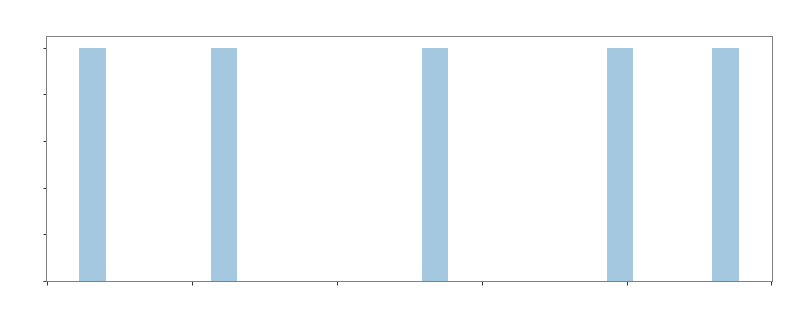

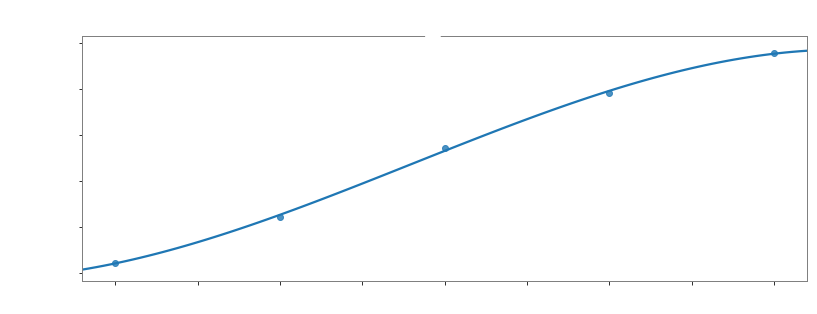

In [7]:
#  Collect grid search data for visualisation
cols = [k for k in grid[0]['params']]
cols.append('f1')
grid_data = pd.DataFrame([], columns=cols)

#  Get the data
for i in range(len(grid)):
    grid_data.loc[i, 'f1'] = grid[i]['f1']
    for p in [k for k in grid[0]['params']]:
        grid_data.loc[i, p] = str_to_number(grid[i]['params'][p])

#  Convert to floats where possible
for col in grid_data.columns:
    try:
        grid_data[col] = grid_data[col].astype(float)
    except:
        pass

#  Plot distribution of F1 scores
fig = sns.distplot(grid_data['f1'], kde=False, bins=25)
fig.set_ylabel('', color='white')
fig.set_xlabel('', color='white')
fig.set_title('F1 score distribution', color='white', size=30)
plt.setp(fig.get_xticklabels(), color='white', size=20)
plt.setp(fig.get_yticklabels(), color='white', size=20)
plt.show()
    
#  Plot regressions
cols = []
for col in grid_data.columns:
    if grid_data[col].dtype != object and len(grid_data[col].unique()) > 1 and col not in ['scale_pos_weight', 'f1']:
        cols.append(col)

for col in cols:
    rcParams['figure.figsize'] = 13, 4.5
    rcParams["axes.labelsize"] = 20
    rcParams['axes.linewidth'] = 1
    rcParams['axes.edgecolor'] = '.5'
    rcParams['legend.frameon'] = False
    
    fig = sns.regplot(data=grid_data, x=col, y='f1', order=3, ci=None) #  Linear regression; order=2 for non-linear
    fig.set_ylabel('F1 score', color='white')
    fig.set_xlabel('', color='white')
    fig.set_title(col, color='white', size=30)
    plt.setp(fig.get_xticklabels(), color='white', size=20)
    plt.setp(fig.get_yticklabels(), color='white', size=20)
    
    plt.show()